# ICA QC and merging with precise data
This is a template notebook for performing preliminary analysis on new expression data in preciseDB context.

## Setup and Import

In [1]:
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from scipy import stats
from tqdm.notebook import tqdm
from pymodulon.core import *
from pymodulon.io import *
from pymodulon.plotting import *

pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

sns.set_style('ticks')

### Define data paths

Enter path of log-TPM, MultiQC, metadata, and matrix files here

In [2]:
gene_table_path = path.join('..','data','transcriptome_data','ecoli_data','annotation','gene_info.csv') # Enter gene table filename here
gene_info = pd.read_csv(gene_table_path, index_col=0)
precise_feature_counts_path = path.join('..','data','transcriptome_data','precise_data','precise_feature_count.csv')
precise_feature_counts = pd.read_csv(precise_feature_counts_path, index_col=0)
trn_table_path = path.join('..','data','transcriptome_data','ecoli_data','annotation','trn.csv') # Enter trn table filename here
trn_table = pd.read_csv(trn_table_path)

In [3]:
precise_log_TPM_path = path.join('..','data','transcriptome_data','precise_data','precise_log_tpm.csv') # Enter precise log-TPM filename here
precise_multiqc_path = path.join('..','data','transcriptome_data','precise_data','precise_multiqc.csv') # Enter MultiQC stats filename here
precise_metadata_path = path.join('..','data','transcriptome_data','precise_data','precise_metadata.csv') # Enter precise metadata filename here

In [4]:
ddb_log_TPM_path = path.join('..','data','transcriptome_data','ddb_data','ddb_log_tpm.csv') # Enter ddb log-TPM filename here
ddb_multiqc_path = path.join('..','data','transcriptome_data','ddb_data','ddb_multiqc.csv') # Enter MultiQC stats filename here
ddb_metadata_path = path.join('..','data','transcriptome_data','ddb_data','ddb_metadata.csv') # Enter ddb metadata filename here

### Load expression data

In [5]:
precise_log_tpm = pd.read_csv(precise_log_TPM_path,index_col=0).fillna(0)
#check to compare index: assert(set(precise_log_tpm.columns) - set(precise_metadata['Unnamed: 0']) == set())
#precise_log_tpm.set_axis(precise_metadata.index, axis=1, inplace=True)
print('Number of genes in precise data set:',precise_log_tpm.shape[0])
print('Number of samples in precise data set:',precise_log_tpm.shape[1])
precise_log_tpm.head()

Number of genes in precise data set: 4211
Number of samples in precise data set: 872


,ecoli_00001,ecoli_00002,ecoli_00003,ecoli_00004,ecoli_00005,ecoli_00006,ecoli_00007,ecoli_00008,ecoli_00009,ecoli_00010,...,ecoli_eep_115,ecoli_eep_116,ecoli_eep_117,ecoli_eep_118,ecoli_eep_119,ecoli_eep_120,ecoli_eep_121,ecoli_eep_122,ecoli_eep_123,ecoli_eep_124
b0002,10.260569,10.368555,11.193605,11.404163,10.497016,10.235690,9.477470,9.811860,10.735874,10.726916,...,10.422879,10.274562,9.367776,9.212529,9.995606,10.097465,10.468791,10.403032,10.731366,10.848618
b0003,9.920277,10.044224,11.045580,11.460140,10.374823,10.216922,9.219235,9.861262,10.528432,10.503092,...,10.108801,10.242438,9.557823,9.317156,10.045444,9.965385,10.085025,10.105781,10.248226,10.275886
b0004,9.936694,10.010638,9.976798,10.330368,9.876910,9.638754,8.258753,8.650959,9.739519,9.722997,...,10.033418,10.050454,9.449727,9.296110,10.004203,9.953080,9.865435,9.765344,10.001485,10.022078
b0005,7.027515,7.237449,6.014337,5.854519,6.950936,6.768425,5.011006,5.137711,6.745798,6.497823,...,5.566189,5.371117,5.637477,5.732791,4.974713,5.424560,6.337322,6.449275,6.805340,6.335057
b0006,6.537183,6.452699,6.371349,6.387164,6.321764,6.405053,6.286808,6.491897,6.460234,6.467135,...,6.619961,6.544654,6.571672,6.453297,6.209206,6.362060,6.687450,6.711131,6.833914,6.847052


In [6]:
ddb_log_tpm = pd.read_csv(ddb_log_TPM_path,index_col=0).fillna(0)
print('Number of genes in ddb data set:',ddb_log_tpm.shape[0])
print('Number of samples in ddb data set:',ddb_log_tpm.shape[1])
ddb_log_tpm.head()

Number of genes in ddb data set: 4211
Number of samples in ddb data set: 486


,SF_0001,SF_0002,SF_0003,SF_0004,SF_0005,SF_0006,SF_0007,SF_0008,SF_0009,SF_0010,...,DDB_0522,DDB_0523,DDB_0524,DDB_0525,DDB_0526,DDB_0527,DDB_0528,DDB_0529,DDB_0530,DDB_0531
b0002,10.839899,10.992075,10.623304,10.895733,10.811472,10.963506,11.041488,10.914195,10.405665,10.844830,...,8.973507,8.852718,8.930996,8.872759,8.753462,8.796789,8.706522,8.687058,7.073381,7.192718
b0003,9.708521,9.558346,9.418140,9.605899,9.764367,9.774836,10.161797,9.323827,9.380837,9.177182,...,8.155925,8.161968,8.206462,8.218207,7.930264,8.098149,8.012460,8.001791,6.328467,6.507705
b0004,10.395865,10.228161,10.001940,10.305250,10.129218,10.331929,10.443093,10.439108,10.289953,10.502304,...,8.770261,8.737298,8.862746,8.812632,8.878381,8.794689,8.638421,8.638761,7.308777,7.347469
b0005,3.706552,5.066304,5.363581,4.995037,4.758288,5.295409,5.351718,4.446360,3.743963,4.314183,...,3.241079,3.988602,3.634977,3.997647,3.233324,3.368563,3.485904,3.197624,1.761573,2.635996
b0006,6.432675,6.531578,6.689765,6.710622,6.323867,6.592046,6.520329,6.797104,6.801912,6.837407,...,5.948567,6.040328,6.107783,6.045673,6.115166,5.864470,5.921679,5.875614,6.367899,6.259849


### Load metadata

It is important to curate the metadata. At a minimum, three columns must be added to the metadata sheet:
* ``project``: Nickname for the project. Each bioproject should have a unique project IDs.
* ``condition``: Nickname for the experimental condition. Biological/technical replicates must have identical condition IDs.
* ``reference_condition``: Condition ID of the reference condition. Each project has a single reference condition (See [example metadata sheet](https://github.com/SBRG/nf-rnaseq-bacteria/blob/master/example_data/processed_data/metadata_curated.tsv))

In [7]:
precise_metadata = pd.read_csv(precise_metadata_path,index_col=0) #use sep='\t', as some cells might conatin ','
print('Number of precise samples with metadata:',precise_metadata.shape)
precise_metadata.head()

Number of precise samples with metadata: (933, 42)


,sample_id,study,project,condition,rep_id,Biological Replicates,run_date,Strain Description,Strain,Base Media,...,Isolate Type,Sequencing Machine,Additional Details,DOI,GEO,Published,SRX,Run,LibraryLayout,Platform
precise_ID,,,,,,,,,,,,,,,,,,,,,
ecoli_00001,control__wt_glc__1,Control,control,wt_glc,1,2,17/04/2013,Escherichia coli K-12 MG1655,MG1655,M9,...,NaN,MiSeq,NaN,doi.org/10.1101/080929,GSE65643,1.0,SRX865357,SRR1787590,PAIRED,ILLUMINA
ecoli_00002,control__wt_glc__2,Control,control,wt_glc,2,2,17/04/2013,Escherichia coli K-12 MG1655,MG1655,M9,...,NaN,MiSeq,NaN,doi.org/10.1101/080929,GSE65643,1.0,SRX865358,SRR1787591,PAIRED,ILLUMINA
ecoli_00003,fur__wt_dpd__1,Fur,fur,wt_dpd,1,2,02/10/2013,Escherichia coli K-12 MG1655,MG1655,M9,...,NaN,MiSeq,NaN,doi.org/10.1038/ncomms5910,GSE54900,1.0,SRX469840,SRR1168135,PAIRED,ILLUMINA
ecoli_00004,fur__wt_dpd__2,Fur,fur,wt_dpd,2,2,02/10/2013,Escherichia coli K-12 MG1655,MG1655,M9,...,NaN,MiSeq,NaN,doi.org/10.1038/ncomms5910,GSE54900,1.0,SRX469841,SRR1168136,PAIRED,ILLUMINA
ecoli_00005,fur__wt_fe__1,Fur,fur,wt_fe,1,2,05/09/2013,Escherichia coli K-12 MG1655,MG1655,M9,...,NaN,MiSeq,NaN,doi.org/10.1038/ncomms5910,GSE54900,1.0,SRX469838,SRR1168133,PAIRED,ILLUMINA


In [8]:
ddb_metadata = pd.read_csv(ddb_metadata_path,index_col=0) #use sep='\t', as some cells might conatin ','
print('Number of ddb samples with metadata:',ddb_metadata.shape)
ddb_metadata.head()

Number of ddb samples with metadata: (486, 31)


,sample_id,study,project,condition,rep_id,Biological Replicates,run_date,Strain Description,Strain,Base Media,...,Isolate Type,Sequencing Machine,Additional Details,DOI,GEO,Published,SRX,Run,LibraryLayout,Platform
precise_ID,,,,,,,,,,,,,,,,,,,,,
SF_0001,DDB-I_SF_S1-001_A3,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],3,9,29/10/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA
SF_0002,DDB-I_SF_S1-001_A4_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],4,9,13/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA
SF_0003,DDB-I_SF_S1-001_A5_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],5,9,19/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA
SF_0004,DDB-I_SF_S1-001_A6_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],6,9,26/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA
SF_0005,DDB-I_SF_S1-001_A4_RNAseq2,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],4,9,11/12/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA


### Load MultiQC data
There may be some datasets that failed along the processing pipeline, so the number of samples with QC data may be higher than the number of samples with expression data.

In [9]:
precise_qc_stats = pd.read_csv(precise_multiqc_path, index_col=0) #use sep='\t', as some cells might conatin ','
precise_qc_stats.fillna(0,inplace=True)
print('Number of samples with QC data:',precise_qc_stats.shape[0])
precise_qc_stats.head()

Number of samples with QC data: 949


,sample_id,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
precise_ID,,,,,,,,,,,,,,,,,,,,,
ecoli_00001,control__wt_glc__1,6372886,4580249,53735,229666,0,0,0,0,164385,...,6496162,201381022,10060007,188572802,6.360192,0.0399,0.4468,0.5133,0.0,0.0
ecoli_00002,control__wt_glc__2,4346353,3183361,26600,199565,0,0,0,0,85094,...,4394188,136219828,6035575,128348546,5.778367,0.0409,0.4453,0.5138,0.0,0.0
ecoli_00003,fur__wt_dpd__1,11421794,8766514,5167,179345,0,0,0,0,12511,...,11445313,354804703,6338224,346636233,2.302244,0.0261,0.5113,0.4626,0.0,0.0
ecoli_00004,fur__wt_dpd__2,10539531,7948124,2907,131778,0,0,0,0,4468,...,10563549,327470019,6001546,319757327,2.355236,0.0234,0.5314,0.4452,0.0,0.0
ecoli_00005,fur__wt_fe__1,10713890,8153912,1176,562512,0,0,0,0,41191,...,10848313,336297703,8690930,325858317,3.104210,0.0314,0.4550,0.5135,0.0,0.0


In [10]:
ddb_qc_stats = pd.read_csv(ddb_multiqc_path, index_col=0) #use sep='\t', as some cells might conatin ','
ddb_qc_stats.fillna(0,inplace=True)
print('Number of samples with QC data:',ddb_qc_stats.shape[0])
ddb_qc_stats.head()

Number of samples with QC data: 486


,sample_id,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
precise_ID,,,,,,,,,,,,,,,,,,,,,
SF_0001,DDB-I_SF_S1-001_A3,5052574,3722459,168227,200941,0,0,0,0,11334,...,5101150,687168259,5641626,679695211,1.087514,0.0238,0.4609,0.5153,0,0
SF_0002,DDB-I_SF_S1-001_A4_RNAseq,6138574,4083306,505811,335390,0,0,0,0,25386,...,6245408,830461611,6717387,821795366,1.043546,0.0241,0.4521,0.5238,0,0
SF_0003,DDB-I_SF_S1-001_A5_RNAseq,3689324,2276304,164721,339574,0,0,0,0,39930,...,3883337,481119425,4214134,469337210,2.448917,0.0380,0.4652,0.4967,0,0
SF_0004,DDB-I_SF_S1-001_A6_RNAseq,1698863,1178943,127920,48478,0,0,0,0,4843,...,1717005,228953900,848407,227476773,0.645164,0.0244,0.4509,0.5247,0,0
SF_0005,DDB-I_SF_S1-001_A4_RNAseq2,12218353,8148636,274385,1476775,0,0,0,0,16120,...,12252550,1705160401,17130314,1673080400,1.881348,0.0199,0.4826,0.4975,0,0


### Check data frame consistency

Ensure that metadata and qc_stats data contain all log_tpm sample information.

In [11]:
print(precise_metadata.shape)
print(precise_log_tpm.shape)

(933, 42)
(4211, 872)


In [12]:
print(ddb_metadata.shape)
print(ddb_log_tpm.shape)

(486, 31)
(4211, 486)


In [13]:
assert(set(ddb_log_tpm.columns) - set(ddb_metadata.index) == set())
assert(set(precise_log_tpm.columns) - set(precise_metadata.index) == set())

assert(set(ddb_log_tpm.columns) - set(ddb_qc_stats.index) == set())
assert(set(precise_log_tpm.columns) - set(precise_qc_stats.index) == set())

## Define functions

In [14]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches

def global_clustering(data, threshold=0.3, xticklabels=False, yticklabels=False, figsize=(9,9)):
    
    # Retrieve clusters using fcluster 
    corr = data.corr()
    corr.fillna(0,inplace=True)
    dist = sch.distance.pdist(corr)
    link = sch.linkage(dist, method='complete')
    clst = pd.DataFrame(index=data.columns)
    clst['cluster'] = sch.fcluster(link, threshold * dist.max(), 'distance')

    # Get colors for each cluster
    cm = plt.cm.get_cmap('tab20')
    cluster_colors = dict(zip(clst.cluster.unique(), cm.colors))
    clst['color'] = clst.cluster.map(cluster_colors)

    print('Number of cluster: ', len(cluster_colors))
    
    legend_items = [patches.Patch(color=c, label=l) for l,c in cluster_colors.items()]
    
    sns.set(rc={'figure.facecolor':'white'})
    
    clst_map = sns.clustermap(data.corr(), 
                              figsize=figsize, 
                              row_linkage=link, 
                              col_linkage=link, 
                              col_colors=clst.color,
                              yticklabels=yticklabels, 
                              xticklabels=xticklabels,
                              vmin=0, 
                              vmax=1)
    
    legend = clst_map.ax_heatmap.legend(loc='upper left', 
                                        bbox_to_anchor=(1.01,0.85), 
                                        handles=legend_items,
                                        frameon=True)
    
    legend.set_title(title='Clusters',prop={'size':10})
    
    return clst['cluster']

In [15]:
def infer_precise_activities(precise, data):
    """
    Infer iModulon activities for external data
    Parameters
    ----------
    data: ~pandas.DataFrame
        External expression profiles (must be centered to a reference)
    Returns
    -------
    new_activities: ~pandas.DataFrame
        Inferred activities for the expression profiles
    """

    shared_genes = precise.M.index & data.index
    x = data.loc[shared_genes].values
    m = precise.M.loc[shared_genes].values
    m_inv = np.linalg.pinv(m)
    a = np.dot(m_inv, x)
    return pd.DataFrame(a, index=precise.imodulon_table.index, columns=data.columns)


### Compare gene sets

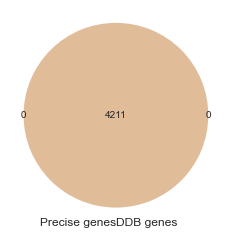

In [16]:
from matplotlib_venn import venn2
venn2((set(precise_log_tpm.index),set(ddb_log_tpm.index)), set_labels=['Precise genes','DDB genes'])

Only genes shared between your ``IcaData`` object and the new expression profiles will be used to project your data. All other genes will be ignored.

## Check QC statistics

There may be some datasets that failed along the processing pipeline, so the number of samples with QC data may be higher than the number of samples with expression data.

### FastQC quality control

The following four categories are the most important: - per_base_sequence_quality - per_sequence_quality_scores - per_base_n_content - adapter_content If a sample does not pass any of these four categories, discard the sample

In [17]:
fastqc_cols = ['per_base_sequence_quality',
       'per_tile_sequence_quality', 'per_sequence_quality_scores',
       'per_base_sequence_content', 'per_sequence_gc_content',
       'per_base_n_content', 'sequence_length_distribution',
       'sequence_duplication_levels', 'overrepresented_sequences',
       'adapter_content']

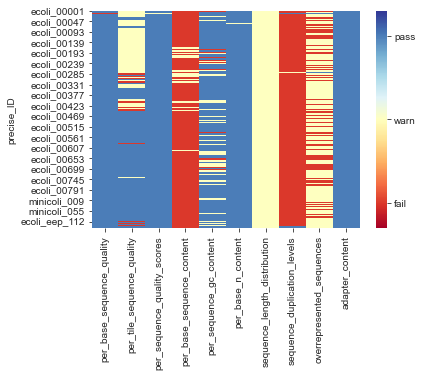

In [18]:
precise_fastqc = precise_qc_stats[fastqc_cols]
ax = sns.heatmap(precise_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),
            cmap='RdYlBu',vmax=1.3,vmin=-1.3)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['fail','warn','pass'])

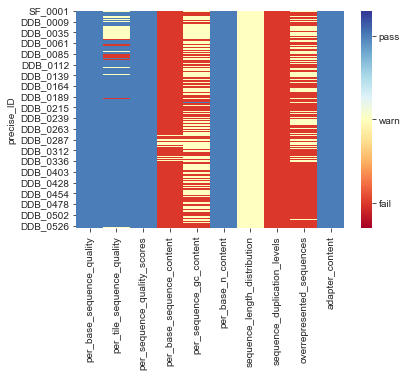

In [19]:
ddb_fastqc = ddb_qc_stats[fastqc_cols]
ax = sns.heatmap(ddb_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),
            cmap='RdYlBu',vmax=1.3,vmin=-1.3)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['fail','warn','pass'])

In [20]:
fastqc_fail_cols = ['per_base_sequence_quality','per_sequence_quality_scores','per_base_n_content','adapter_content']

In [21]:
ddb_failed_fastqc = ddb_fastqc[fastqc_fail_cols][(ddb_fastqc[fastqc_fail_cols] != 'pass').any(axis=1)]
ddb_failed_fastqc[fastqc_fail_cols]

,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
precise_ID,,,,


In [22]:
precise_failed_fastqc = precise_fastqc[fastqc_fail_cols][(precise_fastqc[fastqc_fail_cols] != 'pass').any(axis=1)]
precise_failed_fastqc[fastqc_fail_cols]

,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
precise_ID,,,,
ecoli_00013,fail,warn,pass,pass
ecoli_00056,pass,pass,warn,pass
ecoli_00057,pass,pass,warn,pass
ecoli_00069,fail,pass,fail,pass
ecoli_00076,fail,pass,fail,pass


<font size="4">Mark samples as failed.</font>

In [23]:
ddb_metadata['passed_fastqc'] = ~ddb_metadata.index.isin(ddb_failed_fastqc.index)
precise_metadata['passed_fastqc'] = ~precise_metadata.index.isin(precise_failed_fastqc.index)

## Percent of reads aligned to genome

The following histogram shows how many reads map to coding sequences (i.e. mRNA). Too few aligned reads reduces the sensitivity of the resulting data.

In [24]:
min_pct_aligned = 40 # Minimum percent of reads aligned to genome
min_mrna_reads = 5e5 # Minimum number of reads mapped to mRNA

Text(0.5, 1.0, 'Histogram of Alignment Percentage')

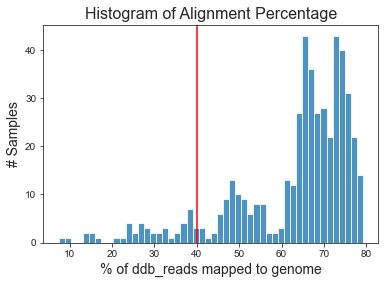

In [25]:
align_cols = ['Assigned']
ddb_total_alignment = ddb_qc_stats[align_cols].sum(axis=1)
ddb_percent_alignment = ddb_total_alignment.divide(ddb_qc_stats['Total'])*100

fig,ax = plt.subplots()
ax.hist(ddb_percent_alignment,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_pct_aligned,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('% of ddb_reads mapped to genome',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Histogram of Alignment Percentage',fontsize=16)

Text(0.5, 1.0, 'Histogram of Alignment Percentage')

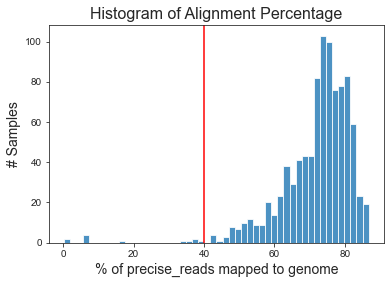

In [26]:
align_cols = ['Assigned']
precise_total_alignment = precise_qc_stats[align_cols].sum(axis=1)
precise_percent_alignment = precise_total_alignment.divide(precise_qc_stats['Total'])*100

fig,ax = plt.subplots()
ax.hist(precise_percent_alignment,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_pct_aligned,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('% of precise_reads mapped to genome',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Histogram of Alignment Percentage',fontsize=16)

In [27]:
ddb_failed_mapping = ddb_qc_stats[ddb_percent_alignment < min_pct_aligned]
ddb_metadata['passed_pct_reads_mapped'] = ~ddb_metadata.index.isin(ddb_failed_mapping.index)
ddb_failed_mapping

,sample_id,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
precise_ID,,,,,,,,,,,,,,,,,,,,,
DDB_0004,DDB_PD_001_RNA_14,5527806,2097157,749787,1562562,0,0,0,0,90369,...,5542738,752889347,3204436,747384697,0.731137,0.0212,0.4115,0.5673,0,0
DDB_0006,DDB_PD_001_RNA_13,6127403,1260630,2121460,1547664,0,0,0,0,98838,...,6137924,837971891,3496180,831672031,0.751798,0.0158,0.3272,0.6570,0,0
DDB_0007,DDB_PD_001_RNA_19,7707156,2021516,1120725,2504877,0,0,0,0,159193,...,7731676,1029190994,2884519,1024166666,0.488182,0.0231,0.4199,0.5570,0,0
DDB_0010,DDB_PD_001_RNA_12,6177046,2361373,883865,1418886,0,0,0,0,173810,...,6188155,797659796,1898386,793981787,0.461100,0.0307,0.4168,0.5525,0,0
DDB_0012,DDB_PD_001_RNA_11,7133926,2024140,1059925,2207798,0,0,0,0,112780,...,7164625,965820839,4759419,957230617,0.889422,0.0217,0.4384,0.5398,0,0
DDB_0013,DDB_PD_001_RNA_17,6353268,1797633,652873,2200574,0,0,0,0,162002,...,6377811,839962683,4851312,829878353,1.200569,0.0284,0.4402,0.5314,0,0
DDB_0017,DDB_PD_001_RNA_10,8575040,3201539,1286974,2288986,0,0,0,0,199569,...,8598891,1141078865,7527525,1124863152,1.421086,0.0252,0.4094,0.5654,0,0
DDB_0018,DDB_PD_001_RNA_16,6975551,2764654,1108691,1653491,0,0,0,0,69554,...,6992748,955230835,4665688,947544970,0.804608,0.0185,0.4174,0.5641,0,0
DDB_0019,DDB_PD_001_RNA_15,7583684,1830322,1850789,2276979,0,0,0,0,101338,...,7605588,1019903620,2390519,1015484812,0.433257,0.0206,0.3803,0.5991,0,0


In [28]:
precise_failed_mapping = precise_qc_stats[precise_percent_alignment < min_pct_aligned]
precise_metadata['passed_pct_reads_mapped'] = ~precise_metadata.index.isin(precise_failed_mapping.index)
precise_failed_mapping

,sample_id,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
precise_ID,,,,,,,,,,,,,,,,,,,,,
ecoli_00151,ssw__xyl_ale1__1,3906008,1537833,1479914,55929,0,0,0,0,9857,...,3922738,137295830,143152,135630362,1.213051,0.4081,0.3212,0.2707,0.0,0.0
ecoli_00156,ssw__glc_ac_glc2__1,4833809,14785,3893423,251465,0,0,0,0,3031,...,4841148,726172200,1536519,656317481,9.619580,0.8505,0.0637,0.0858,0.0,0.0
ecoli_00367,abx_media__camhb_ctrl__1,6409073,2396849,2999202,80540,0,0,0,0,105408,...,6415979,256639160,564443,253273411,1.311471,0.0360,0.2346,0.7294,0.0,0.0
ecoli_00403,hot_tale__hot_ale3_mid_44c__1,4837452,809302,3361607,175788,0,0,0,0,47770,...,4846082,489454282,2006772,485061325,0.897521,0.0611,0.1761,0.7627,0.0,0.0
ecoli_00726,cck_pgi__pgi_ale2__1,9009414,31284,3668370,859929,0,0,0,0,27719,...,9033164,682613640,2339290,678983256,0.531836,0.4545,0.1599,0.3857,0.0,0.0
ecoli_00799,adnB__delydhB_adn__1,4206750,1593431,416287,97804,0,0,0,0,12376,...,4208394,214628094,221755,212514750,0.984654,0.0605,0.5627,0.3768,0.0,0.0
ecoli_00800,adnB__delydhB_adn__2,6136173,2135300,1522795,234165,0,0,0,0,23901,...,6138877,313082727,152877,310451375,0.840465,0.0507,0.4412,0.5081,0.0,0.0
minicoli_005,minicoli__aldA_AC_rna__5,2898115,1052668,160744,1214712,0,0,0,0,22273,...,2910024,125131032,142300,123488083,1.312983,0.2379,0.3040,0.4581,0.0,0.0
ecoli_eep_005,eep__WT-PCR_SRS__1,12188565,726829,10586,10993290,0,0,0,0,110259,...,12242707,1236513407,475939,1226959357,0.772660,0.0582,0.4054,0.5364,0.0,0.0


Text(0.5, 1.0, 'Number of reads mapped to CDS')

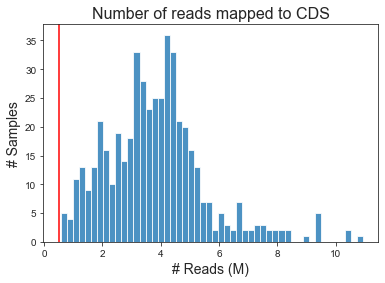

In [29]:
ddb_failed_mrna = ddb_qc_stats[ddb_qc_stats['Assigned'] < min_mrna_reads].sort_values('Assigned')
ddb_failed_mrna
ddb_metadata['passed_reads_mapped_to_CDS'] = ~ddb_metadata.index.isin(ddb_failed_mrna.index)

fig,ax = plt.subplots()
ax.hist(ddb_qc_stats['Assigned']/1e6,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_mrna_reads/1e6,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('# Reads (M)',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Number of reads mapped to CDS',fontsize=16)

Text(0.5, 1.0, 'Number of reads mapped to CDS')

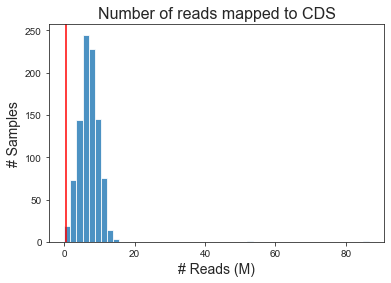

In [30]:
precise_failed_mrna = precise_qc_stats[precise_qc_stats['Assigned'] < min_mrna_reads].sort_values('Assigned')
precise_failed_mrna
precise_metadata['passed_reads_mapped_to_CDS'] = ~precise_metadata.index.isin(precise_failed_mrna.index)

fig,ax = plt.subplots()
ax.hist(precise_qc_stats['Assigned']/1e6,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_mrna_reads/1e6,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('# Reads (M)',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Number of reads mapped to CDS',fontsize=16)

### Examine Global Correlations

We will use a clustermap (hierarchical clustering) to visualize the global correlations between samples. To increase the number of clusters, decrease the value of thresh. 

Only examine data that passed the first two steps.

In [ ]:
precise_metadata_passed_QCstep2 = precise_metadata[precise_metadata[['passed_fastqc','passed_reads_mapped_to_CDS']].all(axis=1)]
precise_log_tpm_passed_QCstep2 = precise_log_tpm[precise_metadata_passed_QCstep2.index]

In [ ]:
ddb_metadata_passed_QCstep2 = ddb_metadata[ddb_metadata[['passed_fastqc','passed_reads_mapped_to_CDS']].all(axis=1)]
ddb_log_tpm_passed_QCstep2 = ddb_log_tpm[ddb_metadata_passed_QCstep2.index]

In [ ]:
ddb_metadata_passed_QCstep2.head(30)

,sample_id,study,project,condition,rep_id,Biological Replicates,run_date,Strain Description,Strain,Base Media,...,DOI,GEO,Published,SRX,Run,LibraryLayout,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS
precise_ID,,,,,,,,,,,,,,,,,,,,,
SF_0001,DDB-I_SF_S1-001_A3,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],3,9,29/10/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0002,DDB-I_SF_S1-001_A4_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],4,9,13/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0003,DDB-I_SF_S1-001_A5_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],5,9,19/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0004,DDB-I_SF_S1-001_A6_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],6,9,26/11/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0005,DDB-I_SF_S1-001_A4_RNAseq2,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],4,9,11/12/2020,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0006,DDB-I_SF_S1-001_A8_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],8,9,01/03/2021,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0007,DDB-I_SF_S1-001_A7_RNA_seq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[MG1655_WT]_[SF]_[A],7,9,20/05/2021,Escherichia coli K-12 MG1655,DDB8,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0008,DDB-I_SF_S1-001_B6_RNAseq_Control_1,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[BW25113_WT]_[SF]_[B],6,8,23/09/2021,Escherichia coli BW25113,DDB7,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True
SF_0009,DDB-I_SF_S1-001_B6_RNAseq,DDB-I_SF_S1-001,ddb-i_sf_s1-001,[DDB_ctrl]_[BW25113_WT]_[SF]_[B],6,8,23/09/2021,Escherichia coli BW25113,DDB7,M9,...,NaN,NaN,NaN,NaN,NaN,PAIRED,ILLUMINA,True,True,True


Number of cluster:  4


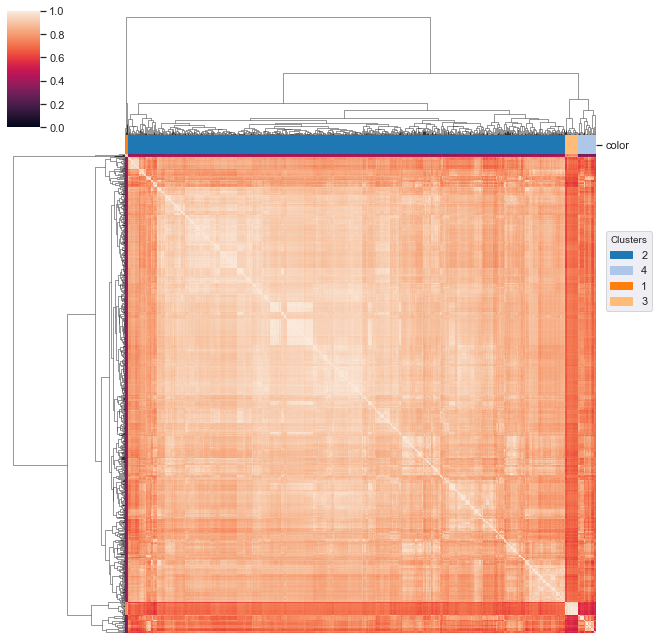

In [ ]:
precise_clusters = global_clustering(precise_log_tpm_passed_QCstep2)

Number of cluster:  8


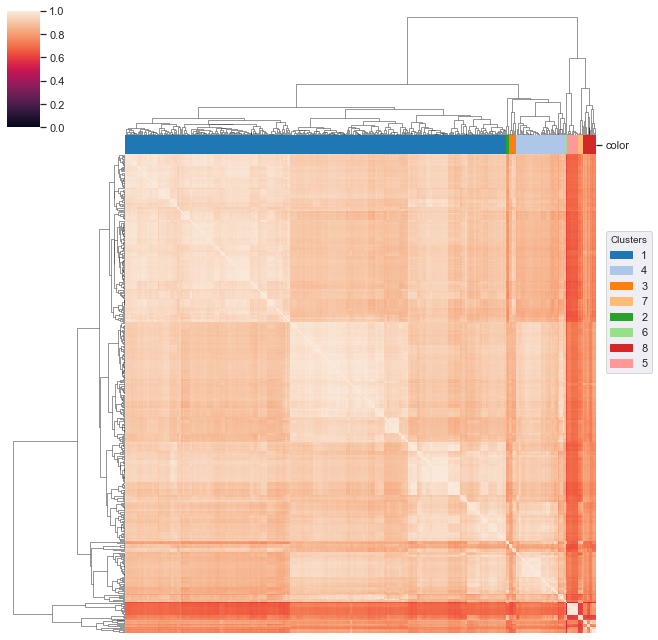

In [ ]:
ddb_clusters = global_clustering(ddb_log_tpm_passed_QCstep2)

Select clusters to remove.

In [ ]:
precise_check_clusters = [1] #check clusters
precise_clusters[precise_clusters.isin(precise_check_clusters)].index

Index(['minicoli_001', 'minicoli_002', 'minicoli_003', 'minicoli_004',
       'minicoli_005'],
      dtype='object')

In [ ]:
precise_remove_clusters = [1] #remove clusters
precise_passed_global_corr = precise_clusters[~precise_clusters.isin(precise_remove_clusters)].index

In [ ]:
ddb_check_clusters = [1,2] #check clusters
ddb_clusters[ddb_clusters.isin(ddb_check_clusters)].index

Index(['SF_0001', 'SF_0002', 'SF_0003', 'SF_0004', 'SF_0005', 'SF_0006',
       'SF_0007', 'SF_0008', 'SF_0010', 'SF_0011',
       ...
       'DDB_0520', 'DDB_0521', 'DDB_0522', 'DDB_0523', 'DDB_0524', 'DDB_0525',
       'DDB_0526', 'DDB_0527', 'DDB_0528', 'DDB_0529'],
      dtype='object', length=396)

In [ ]:
ddb_remove_clusters = [] #remove clusters
ddb_passed_global_corr = ddb_clusters[~ddb_clusters.isin(ddb_remove_clusters)].index

In [ ]:
precise_clusters[precise_clusters == 0]
ddb_clusters[ddb_clusters == 0]

Series([], Name: cluster, dtype: int32)

Re-cluster samples to ensure all outliers were removed.

In [ ]:
precise_log_tpm_passed_QCstep3 = precise_log_tpm[precise_passed_global_corr]
ddb_log_tpm_passed_QCstep3 = ddb_log_tpm[ddb_passed_global_corr]

Once you are satisfied with your dataset, mark the samples that passed the global correlation

In [ ]:
precise_metadata['passed_global_correlation'] = precise_metadata.index.isin(precise_passed_global_corr)

In [ ]:
ddb_metadata['passed_global_correlation'] = ddb_metadata.index.isin(ddb_passed_global_corr)

# Remove failed samples

In [ ]:
qc_columns = ['passed_fastqc',
              'passed_reads_mapped_to_CDS',
              'passed_global_correlation']

In [ ]:
precise_pass_qc = precise_metadata[qc_columns].all(axis=1)
precise_metadata_passed_QCstep3 = precise_metadata[precise_pass_qc]

ddb_pass_qc = ddb_metadata[qc_columns].all(axis=1)
ddb_metadata_passed_QCstep3 = ddb_metadata[ddb_pass_qc]

### Check curation
Since manual curation is error-prone, we want to make sure that all samples have labels for their project and condition. In addition, there should only be one reference condition in each project, and it should be in the project itself.

Any samples that fail these checks will be printed below.

In [ ]:
assert(precise_metadata.project.notnull().all())
assert(precise_metadata.condition.notnull().all())

assert(ddb_metadata_passed_QCstep3.project.notnull().all())
assert(ddb_metadata_passed_QCstep3.condition.notnull().all())

Next, make a new column called ``full_name`` that gives every experimental condition a unique, human-readable identifier.

In [ ]:
precise_metadata_passed_QCstep3['full_name'] = precise_metadata_passed_QCstep3['project'].str.cat(precise_metadata_passed_QCstep3['condition'],sep=':')
ddb_metadata_passed_QCstep3['full_name'] = ddb_metadata_passed_QCstep3['project'].str.cat(ddb_metadata_passed_QCstep3['condition'],sep=':')

### Optional: Remove samples with only one replicate

First, find sample names that have at least two replicates.

In [ ]:
precise_counts = precise_metadata_passed_QCstep3.full_name.value_counts()
precise_keep_samples = precise_counts[precise_counts >= 1].index #keep all samples for now
print(precise_keep_samples)

Index(['ica:wt_glc', 'ros_tale:3_76_0pq', 'ros_tale:16_32_0pq',
       'ros_tale:17_104_250pq', 'ros_tale:18_36_0pq', 'ros_tale:7_103_0pq',
       'ros_tale:19_91_750pq', 'ros_tale:1_112_750pq', 'minspan:wt_glc',
       'cck_sdh:sdh_ale3',
       ...
       '42c:42c_ale4', 'glu:glu_ale6', 'glu:glu_ale8', 'glu:glu_ale9',
       'glu:glu_ale10', '42c:wt_42c', '42c:42c_ale1', '42c:42c_ale2',
       '42c:42c_ale3', '42c:42c_ale6'],
      dtype='object', length=476)


In [ ]:
ddb_counts = ddb_metadata_passed_QCstep3.full_name.value_counts()
#ddb_keep_samples = ddb_counts[ddb_counts >= 2].index #check number of replicates (>=2)
ddb_keep_samples = ddb_counts[ddb_counts >= 1].index #keep all samples for now
print(ddb_keep_samples)

Index(['ddb-i_sf_s1-001:[DDB_ctrl]_[MG1655_WT]_[SF]_[A]',
       'ddb-i_sf_s1-001:[DDB_ctrl]_[BW25113_WT]_[SF]_[B]',
       'ddb_pd_003:[DDB_PD_003]_[DDB7_RiboZero]_[Batch]_[0h]',
       'ddb_pd_003:[DDB_PD_003]_[DDB7_RiboZero]_[Fed-batch]_[21h]',
       'ddb_pd_003:[DDB_PD_003]_[DDB7_RiboZero]_[Fed-batch]_[6h]',
       'ddb_pd_009:[DDB_PD_009]_[DDB27_del_lsrK]_[Fed-batch]_[15h]',
       'ddb_pd_006:[DDB_PD_006]_[DDB29_del_rpoS]_[Fed-batch]_[6h]',
       'ddb_pd_006:[DDB_PD_006]_[DDB25_del_lsrR]_[Fed-batch]_[15h]',
       'ddb_pd_006:[DDB_PD_006]_[DDB28_del_lsrB]_[Fed-batch]_[6h]',
       'ddb_pd_005:[DDB_PD_005]_[DDB12_del_qseB]_[Fed-batch]_[6h]',
       ...
       'ddb_pd_065:[DDB_PD_065]_[DDB7_WT]_[Batch]_[0h]',
       'ddb_pd_009:[DDB_PD_009]_[DDB32_del_baeR]_[Fed-batch]_[16h]',
       'ddb_pd_065:[DDB_PD_065]_[SDT175_del_fur]_[Batch]_[0h]',
       'ddb_pd_063:[DDB_PD_063]_[BL21(DE3)_NEB]_[Fed-batch]_[15h]',
       'ddb_pd_087:[DDB_PD_087]_[SDT288_WT]_[Fed-batch]_[13h]',
       'dd

Only keep these samples

In [ ]:
precise_metadata_passed_QCstep4 = precise_metadata_passed_QCstep3[precise_metadata_passed_QCstep3.full_name.isin(precise_keep_samples)]
print('New number of precise samples with curated metadata:',precise_metadata_passed_QCstep4.shape[0])

ddb_metadata_passed_QCstep4 = ddb_metadata_passed_QCstep3[ddb_metadata_passed_QCstep3.full_name.isin(ddb_keep_samples)]
print('New number of ddb samples with curated metadata:',ddb_metadata_passed_QCstep4.shape[0])

New number of precise samples with curated metadata: 921
New number of ddb samples with curated metadata: 486


## Check correlations between replicates

### Remove failed data from log_tpm files

In [ ]:
precise_log_tpm_passed_QCstep4 = precise_log_tpm[precise_metadata_passed_QCstep4.index]
print('New number of samples remaining in log tpm file:', precise_log_tpm_passed_QCstep4.shape[1])

New number of samples remaining in log tpm file: 921


In [ ]:
ddb_log_tpm_passed_QCstep4 = ddb_log_tpm[ddb_metadata_passed_QCstep4.index]
print('New number of samples remaining in log tpm file:', ddb_log_tpm_passed_QCstep4.shape[1])

New number of samples remaining in log tpm file: 486


### Compute Pearson R Score

Biological replicates should have a Pearson R correlation above 0.95. For samples with more than 2 replicates, the replicates must have R >= 0.95 with at least one other replicate or it will be dropped. The correlation threshold can be changed below:

In [ ]:
rcutoff = 0.95

The following code computes correlations between all samples and collects correlations between replicates and non-replicates.

In [ ]:
precise_rep_corrs = {}
precise_rand_corrs = {}

precise_num_comparisons = len(precise_metadata_passed_QCstep4)*(len(precise_metadata_passed_QCstep4)-1)/2

for exp1,exp2 in tqdm(itertools.combinations(precise_metadata_passed_QCstep4.index,2),total=precise_num_comparisons):
    if precise_metadata_passed_QCstep4.loc[exp1,'full_name'] == precise_metadata_passed_QCstep4.loc[exp2,'full_name']:
        precise_rep_corrs[(exp1,exp2)] = stats.pearsonr(precise_log_tpm_passed_QCstep4[exp1],precise_log_tpm_passed_QCstep4[exp2])[0]
    else:
        precise_rand_corrs[(exp1,exp2)] = stats.pearsonr(precise_log_tpm_passed_QCstep4[exp1],precise_log_tpm_passed_QCstep4[exp2])[0]

/var/folders/21/z9d971_n4lnb6_qm8ydfkg1w0000gp/T/ipykernel_62533/2891376227.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for exp1,exp2 in tqdm(itertools.combinations(precise_metadata_passed_QCstep4.index,2),total=precise_num_comparisons):


  0%|          | 0/423660.0 [00:00<?, ?it/s]

In [ ]:
ddb_rep_corrs = {}
ddb_rand_corrs = {}

ddb_num_comparisons = len(ddb_metadata_passed_QCstep4)*(len(ddb_metadata_passed_QCstep4)-1)/2

for exp1,exp2 in tqdm(itertools.combinations(ddb_metadata_passed_QCstep4.index,2),total=ddb_num_comparisons):
    if ddb_metadata_passed_QCstep4.loc[exp1,'full_name'] == ddb_metadata_passed_QCstep4.loc[exp2,'full_name']:
        ddb_rep_corrs[(exp1,exp2)] = stats.pearsonr(ddb_log_tpm_passed_QCstep4[exp1],ddb_log_tpm_passed_QCstep4[exp2])[0]
    else:
        ddb_rand_corrs[(exp1,exp2)] = stats.pearsonr(ddb_log_tpm_passed_QCstep4[exp1],ddb_log_tpm_passed_QCstep4[exp2])[0]


/var/folders/21/z9d971_n4lnb6_qm8ydfkg1w0000gp/T/ipykernel_62533/2086053024.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for exp1,exp2 in tqdm(itertools.combinations(ddb_metadata_passed_QCstep4.index,2),total=ddb_num_comparisons):


  0%|          | 0/117855.0 [00:00<?, ?it/s]

Correlations can be plotted on a histogram

Median Pearson R between replicates: 0.99


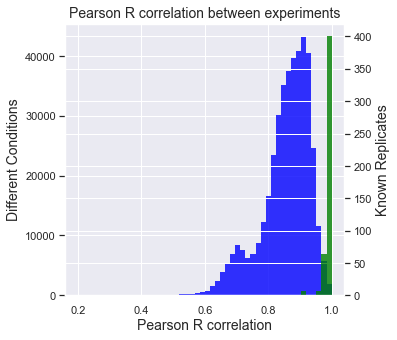

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(precise_rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(precise_rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

precise_med_corr = np.median([v for k,v in precise_rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(precise_med_corr))

Median Pearson R between replicates: 0.99


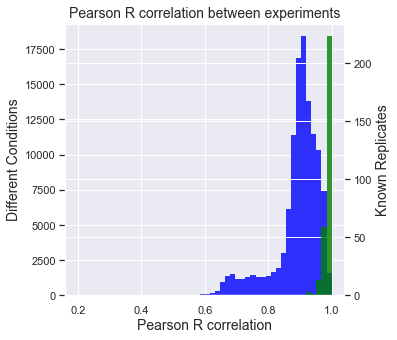

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(ddb_rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(ddb_rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

ddb_med_corr = np.median([v for k,v in ddb_rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(ddb_med_corr))

Remove samples without any high-correlation replicates

In [ ]:
precise_dissimilar = []
for idx, grp in precise_metadata_passed_QCstep4.groupby('full_name'):
    precise_ident = np.identity(len(grp))
    precise_corrs = (precise_log_tpm[grp.index].corr() - precise_ident).max()
    precise_dissimilar.extend(precise_corrs[precise_corrs<rcutoff].index)

# Save this information in both the original metadata dataframe and the new metadata dataframe
precise_metadata_passed_QCstep4['passed_replicate_correlations'] = ~precise_metadata_passed_QCstep4.index.isin(precise_dissimilar)

precise_metadata_qc = precise_metadata_passed_QCstep4[precise_metadata_passed_QCstep4['passed_replicate_correlations']]
precise_log_tpm_qc = precise_log_tpm[precise_metadata_qc.index]
print('Number of samples that passed replicate correlations:',len(precise_metadata_qc))

Number of samples that passed replicate correlations: 859


In [ ]:
ddb_dissimilar = []
for idx, grp in ddb_metadata_passed_QCstep4.groupby('full_name'):
    ddb_ident = np.identity(len(grp))
    ddb_corrs = (ddb_log_tpm[grp.index].corr() - ddb_ident).max()
    ddb_dissimilar.extend(ddb_corrs[ddb_corrs<rcutoff].index)

# Save this information in both the original metadata dataframe and the new metadata dataframe
ddb_metadata_passed_QCstep4['passed_replicate_correlations'] = ~ddb_metadata_passed_QCstep4.index.isin(ddb_dissimilar)

ddb_metadata_qc = ddb_metadata_passed_QCstep4[ddb_metadata_passed_QCstep4['passed_replicate_correlations']]
ddb_log_tpm_qc = ddb_log_tpm[ddb_metadata_qc.index]
print('Number of samples that passed replicate correlations:',len(ddb_metadata_qc))

Number of samples that passed replicate correlations: 444


In [ ]:
#optional: keep non-replicated samples
precise_nr_metadata_qc = precise_metadata_passed_QCstep4
precise_nr_log_tpm_qc = precise_log_tpm[precise_nr_metadata_qc.index]
print('Number of replicated, high quality samples remaining in metadata file:',precise_nr_metadata_qc.shape[0])
print('Number of replicated, high quality samples remaining in log tpm file:',precise_nr_log_tpm_qc.shape[1])


Number of replicated, high quality samples remaining in metadata file: 921
Number of replicated, high quality samples remaining in log tpm file: 921


In [ ]:
#optional: keep non-replicated samples
ddb_nr_metadata_qc = ddb_metadata_passed_QCstep4
ddb_nr_log_tpm_qc = ddb_log_tpm[ddb_nr_metadata_qc.index]
print('Number of replicated, high quality samples remaining in metadata file:',ddb_nr_metadata_qc.shape[0])
print('Number of replicated, high quality samples remaining in log tpm file:',ddb_nr_log_tpm_qc.shape[1])

Number of replicated, high quality samples remaining in metadata file: 486
Number of replicated, high quality samples remaining in log tpm file: 486


## Remove failed data from matrix files and save current metadata, matrix, and tpm data

In [ ]:
precise_metadata_qc_path = path.join('..','data','transcriptome_data','precise_data','precise_metadata_qc.csv') # Enter filename for metadata QC file with only passing datasets
precise_metadata_qc.to_csv(precise_metadata_qc_path, sep=',')

In [ ]:
ddb_metadata_qc_path = path.join('..','data','transcriptome_data','ddb_data','ddb_metadata_qc.csv') # Enter filename for metadata QC file with only passing datasets
ddb_metadata_qc.to_csv(ddb_metadata_qc_path, sep=',')

Remove short and low count genes before merging the new Dataset with Precise

In [ ]:
short_genes = gene_info[(gene_info.end-gene_info.start+1)<100].index.to_list()
print(len(short_genes))
short_genes[0:5]

66


['b0001', 'b0075', 'b4726', 'b4727', 'b4728']

In [ ]:
fpm = precise_feature_counts.divide(precise_feature_counts.sum(axis=0)) * (10**6)
# Sum of column should be 10^6
#fpm['control__wt_glc__1'].sum()
low_fpm_genes = fpm.loc[fpm.max(axis=1) < 10].index.to_list()
drop_genes = list(dict.fromkeys(low_fpm_genes + short_genes)) # dict.fromkeys step removes duplicates
len(drop_genes)

144

## Center log TPM data

In [ ]:
precise_centered_log_tpm = precise_log_tpm_qc.sub(precise_log_tpm_qc[['ecoli_00001','ecoli_00002']].mean(axis=1),axis=0)
print('centered log TPM matrix dimensions:',precise_centered_log_tpm.shape)
precise_centered_log_tpm.head()

centered log TPM matrix dimensions: (4211, 859)


,ecoli_00001,ecoli_00002,ecoli_00003,ecoli_00004,ecoli_00005,ecoli_00006,ecoli_00007,ecoli_00008,ecoli_00009,ecoli_00010,...,ecoli_eep_115,ecoli_eep_116,ecoli_eep_117,ecoli_eep_118,ecoli_eep_119,ecoli_eep_120,ecoli_eep_121,ecoli_eep_122,ecoli_eep_123,ecoli_eep_124
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,0.108317,-0.040000,-0.946786,-1.102033,-0.318957,-0.217097,0.154229,0.088470,0.416804,0.534056
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,0.126551,0.260188,-0.424427,-0.665095,0.063193,-0.016865,0.102775,0.123530,0.265976,0.293635
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,0.059752,0.076788,-0.523939,-0.677556,0.030537,-0.020586,-0.108231,-0.208322,0.027819,0.048412
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-1.566293,-1.761365,-1.495004,-1.399690,-2.157768,-1.707922,-0.795159,-0.683207,-0.327142,-0.797425
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.125019,0.049713,0.076731,-0.041644,-0.285735,-0.132881,0.192509,0.216189,0.338973,0.352111


In [ ]:
precise_nr_centered_log_tpm = precise_nr_log_tpm_qc.sub(precise_nr_log_tpm_qc[['ecoli_00001','ecoli_00002']].mean(axis=1),axis=0)
print('centered log TPM matrix dimensions:',precise_nr_centered_log_tpm.shape)
precise_nr_centered_log_tpm.head()

centered log TPM matrix dimensions: (4211, 921)


,ecoli_00001,ecoli_00002,ecoli_00003,ecoli_00004,ecoli_00005,ecoli_00006,ecoli_00007,ecoli_00008,ecoli_00009,ecoli_00010,...,ecoli_eep_115,ecoli_eep_116,ecoli_eep_117,ecoli_eep_118,ecoli_eep_119,ecoli_eep_120,ecoli_eep_121,ecoli_eep_122,ecoli_eep_123,ecoli_eep_124
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,0.108317,-0.040000,-0.946786,-1.102033,-0.318957,-0.217097,0.154229,0.088470,0.416804,0.534056
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,0.126551,0.260188,-0.424427,-0.665095,0.063193,-0.016865,0.102775,0.123530,0.265976,0.293635
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,0.059752,0.076788,-0.523939,-0.677556,0.030537,-0.020586,-0.108231,-0.208322,0.027819,0.048412
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-1.566293,-1.761365,-1.495004,-1.399690,-2.157768,-1.707922,-0.795159,-0.683207,-0.327142,-0.797425
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.125019,0.049713,0.076731,-0.041644,-0.285735,-0.132881,0.192509,0.216189,0.338973,0.352111


In [ ]:
# Centered against average of all DDB WT controls
ddb_centered_log_tpm = ddb_log_tpm_qc.sub(ddb_log_tpm_qc[['SF_0001','SF_0002','SF_0003','SF_0004','SF_0005','SF_0006','SF_0007','SF_0008','SF_0009','SF_0010','SF_0011','SF_0012','SF_0013','SF_0014','SF_0015','SF_0016']].mean(axis=1),axis=0)
print('centered log TPM matrix dimensions:',ddb_centered_log_tpm.shape)
ddb_centered_log_tpm.head()

centered log TPM matrix dimensions: (4211, 444)


,SF_0001,SF_0002,SF_0003,SF_0004,SF_0005,SF_0006,SF_0007,SF_0008,SF_0009,SF_0010,...,DDB_0522,DDB_0523,DDB_0524,DDB_0525,DDB_0526,DDB_0527,DDB_0528,DDB_0529,DDB_0530,DDB_0531
b0002,0.003854,0.156031,-0.212741,0.059688,-0.024573,0.127461,0.205444,0.078150,-0.430380,0.008786,...,-1.862537,-1.983327,-1.905049,-1.963286,-2.082582,-2.039255,-2.129523,-2.148987,-3.762664,-3.643326
b0003,-0.051488,-0.201662,-0.341869,-0.154110,0.004359,0.014827,0.401789,-0.436181,-0.379171,-0.582827,...,-1.604083,-1.598040,-1.553546,-1.541801,-1.829744,-1.661859,-1.747549,-1.758218,-3.431542,-3.252303
b0004,0.095189,-0.072515,-0.298736,0.004574,-0.171458,0.031253,0.142418,0.138432,-0.010723,0.201629,...,-1.530415,-1.563378,-1.437930,-1.488044,-1.422295,-1.505987,-1.662255,-1.661915,-2.991899,-2.953207
b0005,-1.135092,0.224659,0.521936,0.153393,-0.083357,0.453764,0.510074,-0.395285,-1.097681,-0.527462,...,-1.600566,-0.853043,-1.206667,-0.843998,-1.608321,-1.473082,-1.355741,-1.644020,-3.080072,-2.205648
b0006,-0.124638,-0.025735,0.132452,0.153309,-0.233446,0.034733,-0.036984,0.239791,0.244599,0.280094,...,-0.608746,-0.516985,-0.449530,-0.511640,-0.442148,-0.692843,-0.635634,-0.681699,-0.189414,-0.297464


In [ ]:
# Centered against average of all DDB WT controls
ddb_nr_centered_log_tpm = ddb_nr_log_tpm_qc.sub(ddb_nr_log_tpm_qc[['SF_0001','SF_0002','SF_0003','SF_0004','SF_0005','SF_0006','SF_0007','SF_0008','SF_0009','SF_0010','SF_0011','SF_0012','SF_0013','SF_0014','SF_0015','SF_0016']].mean(axis=1),axis=0)
print('centered log TPM matrix dimensions:',ddb_nr_centered_log_tpm.shape)
ddb_nr_centered_log_tpm.head()

centered log TPM matrix dimensions: (4211, 486)


,SF_0001,SF_0002,SF_0003,SF_0004,SF_0005,SF_0006,SF_0007,SF_0008,SF_0009,SF_0010,...,DDB_0522,DDB_0523,DDB_0524,DDB_0525,DDB_0526,DDB_0527,DDB_0528,DDB_0529,DDB_0530,DDB_0531
b0002,0.003854,0.156031,-0.212741,0.059688,-0.024573,0.127461,0.205444,0.078150,-0.430380,0.008786,...,-1.862537,-1.983327,-1.905049,-1.963286,-2.082582,-2.039255,-2.129523,-2.148987,-3.762664,-3.643326
b0003,-0.051488,-0.201662,-0.341869,-0.154110,0.004359,0.014827,0.401789,-0.436181,-0.379171,-0.582827,...,-1.604083,-1.598040,-1.553546,-1.541801,-1.829744,-1.661859,-1.747549,-1.758218,-3.431542,-3.252303
b0004,0.095189,-0.072515,-0.298736,0.004574,-0.171458,0.031253,0.142418,0.138432,-0.010723,0.201629,...,-1.530415,-1.563378,-1.437930,-1.488044,-1.422295,-1.505987,-1.662255,-1.661915,-2.991899,-2.953207
b0005,-1.135092,0.224659,0.521936,0.153393,-0.083357,0.453764,0.510074,-0.395285,-1.097681,-0.527462,...,-1.600566,-0.853043,-1.206667,-0.843998,-1.608321,-1.473082,-1.355741,-1.644020,-3.080072,-2.205648
b0006,-0.124638,-0.025735,0.132452,0.153309,-0.233446,0.034733,-0.036984,0.239791,0.244599,0.280094,...,-0.608746,-0.516985,-0.449530,-0.511640,-0.442148,-0.692843,-0.635634,-0.681699,-0.189414,-0.297464


In [ ]:
index_list = []
index_list.extend(sorted(precise_centered_log_tpm.columns[precise_centered_log_tpm.columns.str.contains('ecoli')]))
index_list.extend(sorted(precise_centered_log_tpm.columns[precise_centered_log_tpm.columns.str.contains('minicoli')]))
index_list.extend(sorted(ddb_centered_log_tpm.columns[ddb_centered_log_tpm.columns.str.contains('SF')]))
index_list.extend(sorted(ddb_centered_log_tpm.columns[ddb_centered_log_tpm.columns.str.contains('DDB')]))

index_list_nr = []
index_list_nr.extend(sorted(precise_nr_centered_log_tpm.columns[precise_nr_centered_log_tpm.columns.str.contains('ecoli')]))
index_list_nr.extend(sorted(precise_nr_centered_log_tpm.columns[precise_nr_centered_log_tpm.columns.str.contains('minicoli')]))
index_list_nr.extend(sorted(ddb_nr_centered_log_tpm.columns[ddb_nr_centered_log_tpm.columns.str.contains('SF')]))
index_list_nr.extend(sorted(ddb_nr_centered_log_tpm.columns[ddb_nr_centered_log_tpm.columns.str.contains('DDB')]))

In [ ]:
print(len(index_list))
print(len(index_list_nr))

1303
1407


In [ ]:
print(precise_centered_log_tpm.shape)
print(ddb_centered_log_tpm.shape)

(4211, 859)
(4211, 444)


## Join precise + DDB data

In [ ]:
precise_ddb_nr_log_tpm_qc = pd.concat(
    [precise_nr_log_tpm_qc, ddb_nr_log_tpm_qc],
    axis=1,
    join="outer",
    )

precise_ddb_nr_log_tpm_qc = precise_ddb_nr_log_tpm_qc.reindex(index_list_nr, axis=1)

precise_ddb_nr_log_tpm_qc_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_nr_log_tpm_qc.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_nr_log_tpm_qc.to_csv(precise_ddb_nr_log_tpm_qc_path, sep=',')

precise_ddb_centered_log_tpm = pd.concat(
    [precise_centered_log_tpm, ddb_centered_log_tpm],
    axis=1,
    join="outer",
    )

precise_ddb_centered_log_tpm = precise_ddb_centered_log_tpm.reindex(index_list, axis=1)

precise_ddb_centered_log_tpm_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_centered_log_tpm.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_centered_log_tpm.to_csv(precise_ddb_centered_log_tpm_path, sep=',')

precise_ddb_nr_centered_log_tpm = pd.concat(
    [precise_nr_centered_log_tpm, ddb_nr_centered_log_tpm],
    axis=1,
    join="outer",
    )

precise_ddb_nr_centered_log_tpm = precise_ddb_nr_centered_log_tpm.reindex(index_list_nr, axis=1)

precise_ddb_nr_centered_log_tpm_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_nr_centered_log_tpm.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_nr_centered_log_tpm.to_csv(precise_ddb_nr_centered_log_tpm_path, sep=',')

precise_ddb_metadata_qc = pd.concat(
    [precise_metadata_qc, ddb_metadata_qc],
    axis=0,
    join="outer",
    )

precise_ddb_metadata_qc = precise_ddb_metadata_qc.reindex(index_list, axis=0)

precise_ddb_metadata_qc_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_metadata_qc.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_metadata_qc.to_csv(precise_ddb_metadata_qc_path, sep=',')


precise_ddb_nr_metadata_qc = pd.concat(
    [precise_nr_metadata_qc, ddb_nr_metadata_qc],
    axis=0,
    join="outer",
    )

precise_ddb_nr_metadata_qc = precise_ddb_nr_metadata_qc.reindex(index_list_nr, axis=0)

precise_ddb_nr_metadata_qc_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_nr_metadata_qc.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_nr_metadata_qc.to_csv(precise_ddb_nr_metadata_qc_path, sep=',')

precise_ddb_qc_stats = pd.concat(
    [precise_qc_stats, ddb_qc_stats],
    axis=0,
    join="outer",
    )

precise_ddb_nr_qc_stats = precise_ddb_qc_stats[precise_ddb_qc_stats.index.isin(precise_ddb_nr_metadata_qc.index)]

precise_ddb_nr_qc_stats = precise_ddb_nr_qc_stats.reindex(index_list_nr, axis=0)

precise_ddb_nr_qc_stats_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_nr_qc_stats.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_nr_qc_stats.to_csv(precise_ddb_nr_qc_stats_path, sep=',')

In [ ]:
ddb_log_tpm_qc_path = path.join('..','data','transcriptome_data','ddb_data','ddb_log_tpm_qc.csv') # Enter filename for log tpm file with QC passing datasets
ddb_log_tpm_qc.to_csv(ddb_log_tpm_qc_path, sep=',')

ddb_nr_log_tpm_qc_path = path.join('..','data','transcriptome_data','ddb_data','ddb_log_tpm_nr_qc.csv') # Enter filename for log tpm file with QC passing datasets
ddb_nr_log_tpm_qc.to_csv(ddb_nr_log_tpm_qc_path, sep=',')

ddb_centered_log_tpm_path = path.join('..','data','transcriptome_data','ddb_data','ddb_centered_log_tpm.csv') # Enter filename for centered log tpm file with QC passing datasets
ddb_centered_log_tpm.to_csv(ddb_centered_log_tpm_path, sep=',')

In [ ]:
precise_log_tpm_qc_path = path.join('..','data','transcriptome_data','precise_data','precise_log_tpm_qc.csv') # Enter filename for metadata QC file with only passing datasets
precise_log_tpm_qc.to_csv(precise_log_tpm_qc_path, sep=',')

precise_nr_log_tpm_qc_path = path.join('..','data','transcriptome_data','precise_data','precise_log_tpm_nr_qc.csv') # Enter filename for log tpm file with QC passing datasets
precise_nr_log_tpm_qc.to_csv(precise_nr_log_tpm_qc_path, sep=',')

precise_centered_log_tpm_path = path.join('..','data','transcriptome_data','precise_data','precise_centered_log_tpm.csv') # Enter filename for metadata QC file with only passing datasets
precise_centered_log_tpm.to_csv(precise_centered_log_tpm_path, sep=',')

## Remove specific conditions (genome reduced strains etc.)

In [ ]:
#Optional: remove specific conditions
excluded_conditions = ['GenRed','BL21', 'SDT288', 'SDT405', 'RiboZero', 'Qiagen', 'NEB', 'RiboRid', 'minE', 'W3110']

excluded_index = []

for i in excluded_conditions:
    excluded_index.extend(precise_ddb_metadata_qc[
                                    precise_ddb_metadata_qc.condition.str.contains(f'{i}', regex=False)
                                    ].index)

precise_ddb_ica_centered_log_tpm_qc = precise_ddb_centered_log_tpm.drop(excluded_index, axis=1)
precise_ddb_ica_metadata_qc = precise_ddb_metadata_qc.drop(excluded_index, axis=0)

precise_ddb_ica_centered_log_tpm_qc_path = path.join('..','data','transcriptome_data','precise_data','precise_ddb_ica_centered_log_tpm_qc.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_ica_metadata_qc_path = path.join('..','data','transcriptome_data','precise_data','precise_ddb_ica_centered_log_tpm_qc.csv') # Enter filename for centered log tpm file with QC passing datasets

precise_ddb_ica_centered_log_tpm_qc.to_csv(precise_ddb_ica_centered_log_tpm_qc_path, sep=',')
precise_ddb_ica_metadata_qc.to_csv(precise_ddb_ica_metadata_qc_path, sep=',')

print(precise_ddb_ica_centered_log_tpm_qc.shape)
print(precise_ddb_ica_metadata_qc.shape)

(4211, 1207)
(1207, 48)


## Option 1: Perform ICA decomposition and load A+M matrix data combined data set

In [ ]:
precise_ddb_A_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_400_A_curated.csv') # Enter ddb A matrix filename here
precise_ddb_M_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_400_M_curated.csv') # Enter ddb M matrix filename here
precise_ddb_imodulon_table_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_400_imodulon_table_curated.csv') # Enter ddb M matrix filename here

precise_ddb_A = pd.read_csv(precise_ddb_A_path,index_col=0) #use sep='\t', as some cells might conatin ','
print('Number of precise samples with A matrix data:', precise_ddb_A.shape)
precise_ddb_M = pd.read_csv(precise_ddb_M_path,index_col=0) #use sep='\t', as some cells might conatin ','
print('Number of precise samples with M data:', precise_ddb_M.shape)
precise_ddb_imodulon_table = pd.read_csv(precise_ddb_imodulon_table_path,index_col=0) #use sep='\t', as some cells might conatin ','
print('imodulons matrix data:', precise_ddb_imodulon_table.shape)

Number of precise samples with A matrix data: (266, 1207)
Number of precise samples with M data: (4211, 266)
imodulons matrix data: (266, 19)


In [ ]:
precise_ddb_json_data = IcaData(M = precise_ddb_M,
                        A = precise_ddb_A,
                        X = precise_ddb_ica_centered_log_tpm_qc,
                        gene_table = gene_info,
                        sample_table = precise_ddb_ica_metadata_qc,
                        imodulon_table = precise_ddb_imodulon_table,
                        trn = trn_table,
                        optimize_cutoff=True)

#precise_ddb_json_data_path = path.join('..','precise_ddb_data','precise_ddb_400')
#save_to_json(precise_ddb_json_data,precise_ddb_json_data_path, compress=True)

In [ ]:
nr_X = precise_ddb_nr_centered_log_tpm[list(set(precise_ddb_nr_centered_log_tpm.columns) - set(precise_ddb_ica_centered_log_tpm_qc.columns))]
nr_A = infer_precise_activities(precise_ddb_json_data, nr_X)

precise_ddb_nr_A = pd.concat(
    [precise_ddb_A, nr_A],
    axis=1,
    join="outer",
    )

precise_ddb_nr_A = precise_ddb_nr_A.reindex(precise_ddb_nr_centered_log_tpm.columns, axis=1)

precise_ddb_nr_A_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_400_nr_A_curated.csv') # Enter filename for centered log tpm file with QC passing datasets
precise_ddb_nr_A.to_csv(precise_ddb_nr_A_path, sep=',')


/var/folders/21/z9d971_n4lnb6_qm8ydfkg1w0000gp/T/ipykernel_62533/2473072954.py:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  shared_genes = precise.M.index & data.index


In [119]:
precise_ddb_nr_json_data = IcaData(M = precise_ddb_M,
                        A = precise_ddb_nr_A,
                        X = precise_ddb_nr_centered_log_tpm,
                        gene_table = gene_info,
                        sample_table = precise_ddb_nr_metadata_qc,
                        imodulon_table = precise_ddb_imodulon_table,
                        trn = trn_table,
                        optimize_cutoff=True)

precise_ddb_nr_json_data_path = path.join('..','data','transcriptome_data','precise_ddb_data','precise_ddb_400_nr')
save_to_json(precise_ddb_nr_json_data,precise_ddb_nr_json_data_path, compress=True)